<a href="https://colab.research.google.com/github/MaraniMatias/Ahorcado/blob/master/03_d_Speaker_Recognition_v0.0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speaker Recognition

- [Speaker-Diarization](https://github.com/chrisspen/Speaker-Diarization)
- [Vision Transformer - Pytorch]()https://github.com/lucidrains/vit-pytorch
- [Audio manipulation with torchaudio](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#feature-extractions)
- [What’s wrong with CNNs and spectrograms for audio processing?](https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd)
- [Multi-Label Image Classification with PyTorch and Deep Learning](https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/)

### NOTAS

Usar el data set, en spañol, para armar conversaciones de 2 participantes, mesclando los distintos audios, asi puede saber en que momento esta hablando cada participante.

__TODO ver el tiema que el audio empiesa en sinlencio, habla, y sigue en silencio eliminar el silencio o ver como marcarlo con 0, en lugar de que esta halando__

resultado

| Speaker / Time |   |   |     |    |    |     |    |     |     |   |     |     |     |    |
|----------------|---|---|-----|----|----|-----|----|-----|-----|---|-----|-----|-----|----|
| 0              | 1 | 1 |     |    |    |     |    |     |     | 1 |     |     |     |    |
| 1              |   |   | .75 | .8 | .6 |     |    |     |     |   | .78 | .89 | .98 |    |
| 2              |   |   |     |    |    | .78 | .9 | .67 | .89 |   |     |     |     | .9 |


### Simple verson

-1 speaker 1

0 speaker 0

1 speaker -1


| t0 | t1 | t3 |  |  |  |  |  |  |  | |  | |  | tN |
| -| -| | -| -| -| - | - | - | - |- | - | -| - |- |
| 0| 0| 0| -0.93 | -0.83| 0| 0 | 0.98 | 0.34 |  | |  | |  | |




# Pre start


## Contect to Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


## Prepare environment

In [2]:
!rm -drf /content/sample_data
!mkdir -p /content/outputs

!sudo apt install ffmpeg -f

!pip3 install --upgrade pip
!pip3 install youtube_dl
!pip install --upgrade google-api-python-client
# !pip3 install librosa
# !pip3 install scikit-learn
!pip3 install vit-pytorch
!pip3 install torchaudio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
     |████████████████████████████████| 1.6 MB 4.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 7.4 MB 5.1 MB/s 
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.0.4
    Uninstalling google-auth-httplib2-0.0.4:
      Successfully uninstalled google-auth-httplib2-0.0.4
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    U

## Reset GPU RAM

In [3]:
!nvidia-smi
!ps -aux|grep python

Mon Aug 30 14:53:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# !kill -9 4930  4950

# DataSet

## Imports

In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
from glob import glob
from tensorflow import keras
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm # Jupyter

## Downloader Spanish audio by speakers


In [6]:
def download_speaker_dataset(saveto, dataset_name_list):

  for dataset_item in dataset_name_list:
    dataset_name = dataset_item["speaker"]
    dataset_file = dataset_name.split("/")[1]
  
    path_dataset_file =  os.path.join(os.getcwd(), f"{dataset_file}.zip")
    extract_file_path = os.path.join(saveto, dataset_file)
    
    if not os.path.exists(extract_file_path):
      keras.utils.get_file(
        path_dataset_file,
        f"https://www.openslr.org/resources/{dataset_name}.zip",
        extract=False,
        archive_format="zip",
        cache_dir=".",
      )
    
      with zipfile.ZipFile(path_dataset_file, 'r') as zip_ref:
        zip_ref.extractall(extract_file_path)
      os.remove(path_dataset_file)

    dataset_item["wavs"] = glob( os.path.join(extract_file_path, "*.wav"), recursive=True)
    
  return dataset_name_list

## Get specgram

In [7]:
def get_specgram(file_path, sample_rate=None, n_fft=1024, n_mels=128):
  import torch
  import torchaudio
  import torchaudio.transforms as T

  # output length = (seconds) * (sample rate) / (hop_length) 
  transforms = T.MelSpectrogram(
      sample_rate=sample_rate,
      n_fft=n_fft,
      #  win_length=None,
      #  hop_length=None,
      #  center=True,
      #  pad_mode="reflect",
      #  power=2.0,
      n_mels=n_mels
    )


  signal, sr = torchaudio.load(file_path, normalize=True)
  if signal.shape[0] > 1:
      signal = torch.mean(signal, dim=0, keepdim=True)

  if sr != sample_rate:
    resampler = torchaudio.transforms.Resample(sr, sample_rate)
    signal = resampler(signal)

  mel_specgram = transforms(signal)
  # mel_specgram = librosa.power_to_db(mel_specgram)
  mel_specgram = mel_specgram.squeeze()
  mel_specgram /=  n_mels

  return mel_specgram, signal.shape[1]

## Plot Spectrogram

In [8]:
def plot_spectrogram(spec, title=None):
  import librosa
  import matplotlib as mpl
  import matplotlib.pyplot as plt

  mpl.rcParams['figure.dpi'] = 125

  if spec.shape[0] == 1:
    spec = spec[0]

  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel('freq_bin')
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

## Chose random speaker and make audio file

In [9]:
# TODO ver el tiema que el audio empiesa en sinlencio, habla, y sigue en silencio
# eliminar el silencio o ver como marcarlo con 0, en lugar de que esta halando
def get_speakers(size, length=3):
  from numpy import random
  mylist = []
  while len(mylist) < length:
    mylist = random.randint(0, size, length)
    mylist = list(dict.fromkeys(mylist))
  return mylist


def make_random_audio(
    dataset_name_list,
    choose=10, 
    sample_rate=None, 
    n_fft=1024, 
    n_mels=128
  ):
  from numpy import random
  import librosa

  hop_length =  n_fft // 2
  frame_rate = sample_rate/hop_length
  audio_parts = np.zeros([n_mels,0])

  speakers = get_speakers(len(dataset_name_list)-1, length=3)
  label_parts = []
  
  total = 0 
  last_wave_frame = 0
  for _ in range(random.randint(2, choose)):
    ## guardo el elemento 0 para None
    speaker_index =  random.randint(1,len(speakers))
    speaker_number =  speakers[speaker_index]
    mel_sgram = None
    if speaker_number == None:
      print("TODO add nose")
      # TODO  Improve audio nose
      # import torchaudio.transforms as T
    else:
      speaker = dataset_name_list[speaker_number]
      file_path = random.choice(speaker["wavs"])
    
      mel_sgram, wave_len = get_specgram(file_path, sample_rate=sample_rate, n_fft=n_fft, n_mels=n_mels)
      # join spec
      if mel_sgram.shape[0] == 1:
        mel_sgram = mel_sgram[0]

      # time = wave_len/sample_rate
      # print("Wave time:",time, "-> in seg:", round(time))
      # print("Label:", round(time*1000) )
      # print("Spec time:", round(mel_sgram.shape[1] / frame_rate*1000))

    audio_parts = np.concatenate((audio_parts, mel_sgram),axis=1)

    sgram_time_label = round(mel_sgram.shape[1]/frame_rate) # 1000 in miliseg
    total += mel_sgram.shape[1]/frame_rate
    # Join past frame
    for _ in range(sgram_time_label):
      speak = 0
      if speaker_index == 1:
        speak = -1
      elif speaker_index == 2:
        speak = 1
      label_parts.append(speak)
    
  delta = round(total) - len(label_parts)
  if delta > 0:
    for _ in range(delta):
      label_parts.append(0)
    
  return audio_parts, label_parts

## Make Dataset return input and output list

In [10]:
## sampling rate = 1025, 22050, 44100 samples per second. 
def make_dataset(
    speakers_audio_list, 
    save_path=".", 
    dataset_size=100, 
    test_dataset_size=0, 
    choose=10, 
    sample_rate=None,
    n_fft=1024,
    n_mels=128
  ):
  if n_fft < 1024 or n_mels < 128:
    raise Exception('n_fft or n_mels is smaller ')
  total_dataset_size = dataset_size + test_dataset_size
  dataset_x = []
  dataset_y = []

  pbar = tqdm(total=total_dataset_size)

  max_dim_label = 0
  max_dim = 0
  for i in range(total_dataset_size):
    pbar.set_description("Chose rando audio")
    pbar.update(1)
    mel_sgram, label = make_random_audio(
        speakers_audio_list, choose=choose, sample_rate=sample_rate,
        n_fft=n_fft, n_mels=n_mels
      )

    mel_sgram_size = mel_sgram.shape[1]
    if mel_sgram_size > max_dim:
      max_dim = mel_sgram_size

    file_path = os.path.join('.','datasets', f"temp_{i}" )
    np.savez_compressed(file_path, mel_sgram)
    dataset_x.append(file_path + ".npz")

    label_size = len(label)
    if label_size > max_dim_label:
      max_dim_label = label_size

    label_path = os.path.join('.','datasets', f"temp_label_{i}" )
    np.savez_compressed(label_path, label)
    dataset_y.append(label_path + ".npz")

  pbar.reset()
  
  # print("old max",max_dim, max_dim_label)
  # hop_length =  n_fft // 2
  # frame_rate = sample_rate/hop_length
  # max_dim_label_2 = round(max_dim/frame_rate) # *1000 in miliseg
  # print("New max",max_dim, max_dim_label)
  # if max_dim_label_2 - max_dim_label >10:
  #   print(
  #       "max_dim_label:",max_dim_label, 
  #       "max_dim_label_2",max_dim_label_2
  #     )

  file_csv = {"label": [], 'sgram': [] }
  ids = 0
  for x_and_y in zip(dataset_x, dataset_y):
    pbar.update(1)
    pbar.set_description("Make sgram to image")

    ## SPEC
    temp_file_path = x_and_y[0]
    aux = np.load(temp_file_path)['arr_0']
    temp = np.zeros((n_mels, max_dim))
    temp[:aux.shape[0], :aux.shape[1]] = aux

    sgram_path = os.path.join(save_path, f"sgram_{ids}")
    np.savez_compressed(sgram_path, temp)
    file_csv["sgram"].append(sgram_path + ".npz")
    os.remove(temp_file_path)

    if  max_dim != temp.shape[1]:
      raise Exception(f"Diferent size for max_dim {max_dim} gpt {temp.shape[1]}")

    ## LABEL
    temp_file_path = x_and_y[1]
    aux = np.load(temp_file_path)['arr_0']
    delta_label =  max_dim_label - len(aux)
    temp_label = aux
    if delta_label > 0:
      temp_label = np.zeros(delta_label)
      temp_label = np.concatenate((aux, temp_label), axis=0)
    os.remove(temp_file_path)

    label_path = os.path.join(save_path, f"label_{ids}")
    np.savez_compressed(label_path, temp_label)
    file_csv["label"].append(label_path + ".npz")
    
    if delta_label > 0 and max_dim_label != len(temp_label):
      raise Exception(f"Diferent size for max_dim_label {max_dim_label} got {len(temp_label)}")

    ids = ids + 1

  cvs_file_path = os.path.join(save_path, "dataset_image_label.csv")
  csv_data_frame = pd.DataFrame(file_csv)
  csv_data_frame.to_csv(cvs_file_path, index=False)

  if test_dataset_size > 0:
    cvs_test_file_path = os.path.join(save_path, "dataset_test_image_label.csv")
    csv_test = csv_data_frame.tail(test_dataset_size).to_csv(cvs_test_file_path, index=False)
    csv_train_file = csv_data_frame.head(dataset_size).to_csv(cvs_file_path, index=False)
    return  cvs_file_path, cvs_test_file_path
  else: 
    return  cvs_file_path, None

## Show random mel_sgram

In [11]:
def show_random_mel_sgram(cvs_file_path, sample_rate=44000, n_fft=1024 ):
  import matplotlib as mpl
  import matplotlib.pyplot as plt

  mpl.rcParams['figure.dpi'] = 125
  cvs_file = pd.read_csv(cvs_file_path)
  idx = np.random.choice(range(cvs_file.shape[0]))

  label_path = cvs_file["label"].iloc[idx]
  sgram_path = cvs_file["sgram"].iloc[idx]

  sgram = np.load(sgram_path)['arr_0']
  plot_spectrogram(sgram, f"Spectrogram (db) {idx}")

  label = np.load(label_path)['arr_0']

  mpl.rcParams['figure.dpi'] = 96
  plt.plot(range(label.shape[0]),label, marker='o', linestyle='dashed')
  plt.show() 
  print("\nLabel:", label.shape[0], "\nSgram:", sgram.shape)

  hop_length = n_fft // 2
  frame_rate = sample_rate / hop_length
  print("Time spec in secons:", round( sgram.shape[1] / frame_rate ) ) 
  print("Time label in secons:", label.shape[0] )
  # display(label)
  
  return label.shape[0], sgram.shape 

## Load dataset

In [14]:
DATASET_ON_GDRIVE_PATH = "QUTAP/Kolls/Equipo Técnico/kolls_dataaset_files"
SAVE_DATASET_PATH = os.path.join(os.getcwd(),'gdrive/MyDrive', DATASET_ON_GDRIVE_PATH, "dataset_speakers_2_specgram_label")
SAVE_RAW_FILE_PATH = os.path.join(os.getcwd(), "dataset_raw_files")

SAVE_DATASET_PATH = os.path.join(os.getcwd(), 'datasets')

DATASET_SIZE = 3000 #20000
TEST_DATASET_SIZE = 300 #2000

SKIP = not True

SAMPLE_RATE=10240
N_FFT=1024
if SKIP == False:
  DATASET_NAME_LIST = [
    {"speaker":"61/es_ar_female"  , "wavs":[]},
    {"speaker":"61/es_ar_male",     "wavs":[]},
    {"speaker":"71/es_cl_female"  , "wavs":[]},
    {"speaker":"71/es_cl_male",     "wavs":[]},
    {"speaker":"72/es_co_female"  , "wavs":[]},
    {"speaker":"72/es_co_male",     "wavs":[]},
    {"speaker":"73/es_pe_female"  , "wavs":[]},
    {"speaker":"73/es_pe_male",     "wavs":[]},
    {"speaker":"75/es_ve_female"  , "wavs":[]},
    {"speaker":"75/es_ve_male",     "wavs":[]},
    {"speaker":"74/es_pr_female"  , "wavs":[]}
  ]

  speakers_audio_list = download_speaker_dataset(SAVE_RAW_FILE_PATH, DATASET_NAME_LIST)
  cvs_file_path, cvs_test_file_path = make_dataset(
      speakers_audio_list, 
      choose=25,
      save_path=SAVE_DATASET_PATH, 
      dataset_size=DATASET_SIZE,
      test_dataset_size=TEST_DATASET_SIZE,
      sample_rate=SAMPLE_RATE,
      n_fft=N_FFT
    )
  
else:
  cvs_file_path = os.path.join(SAVE_DATASET_PATH, 'dataset_image_label.csv')
  cvs_test_file_path =  os.path.join(SAVE_DATASET_PATH, 'dataset_test_image_label.csv')
  
# display(cvs_file_path)
# display(cvs_test_file_path)

214196224/214181314 [==============================] - 8s 0us/step


  0%|          | 0/3300 [00:00<?, ?it/s]

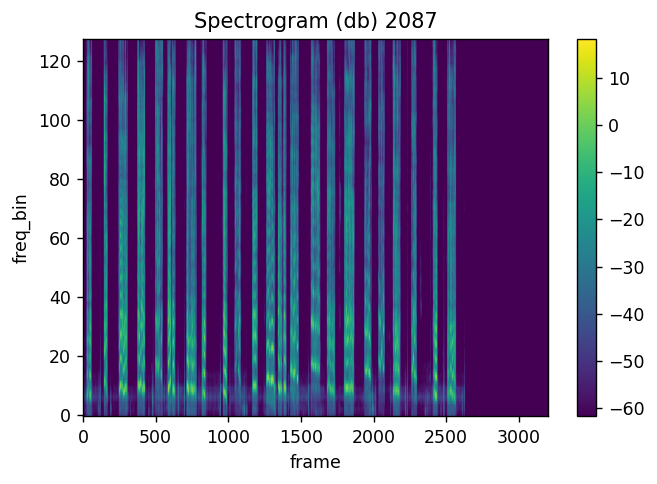

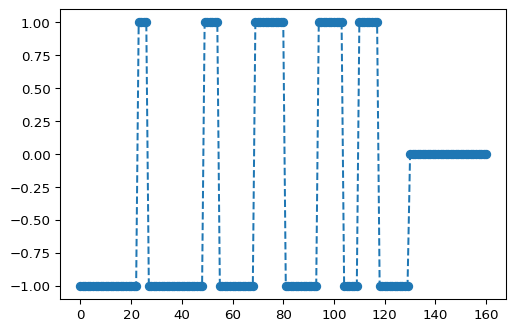


Label: 161 
Sgram: (128, 3200)
Time spec in secons: 160
Time label in secons: 161


(161, (128, 3200))

In [15]:
show_random_mel_sgram(cvs_file_path, sample_rate=SAMPLE_RATE, n_fft=N_FFT)

# The Beginer

# Developing Custom PyTorch Dataloaders

- https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
- https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html#developing-custom-pytorch-dataloaders

## Get Numers Class And Iage Size

In [16]:
def get_numers_class_and_image_size(cvs_file_path):
  cvs_file = pd.read_csv(cvs_file_path)

  label_path = cvs_file["label"].iloc[0]
  label = np.load(label_path)['arr_0']

  sgram_path = cvs_file["sgram"].iloc[0]
  sgram = np.load(sgram_path)['arr_0']

  return len(label), sgram.shape

## Part 1: The Dataset

In [17]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## 1.2 Create a dataset class

In [18]:
class FaceLandmarksDataset(Dataset):
  """Face Landmarks dataset."""

  def __init__(self, csv_file, root_dir=".", transform=None):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    self.lines = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.lines)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    sgram_path = self.lines["sgram"].iloc[idx]
    sgram_name = os.path.join(self.root_dir, sgram_path)
    sgram = np.load(sgram_name)["arr_0"]
    # sgram = np.moveaxis(sgram, -1, 0)
    sgram = torch.tensor(sgram,  dtype=torch.float32)

    label_path = self.lines["label"].iloc[idx]
    speaker = np.load(label_path)["arr_0"]
    speaker = torch.tensor(speaker,  dtype=torch.float32)

    sample = {'sgram': sgram, 'speaker': speaker}

    if self.transform:
      sample = self.transform(sample)

    return sample

# The Beginning - PyTorch

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

## Get output CNN feacture

In [20]:
"""
you can use this formula [(W−K+2P)/S]+1.
    W is the input volume - in your case 128
    K is the Kernel size - in your case 5
    P is the padding - in your case 0 i believe
    S is the stride - which you have not provided.
"""
def cnn_output(n_input,kernel_size,padding=0,stride=1):
  cal = (n_input - kernel_size + 2*padding) / stride
  return cal + 1

def cnn_get_padding(n_input,n_outpout, kernel_size,stride=1):
  return ( (n_outpout-1) *stride -n_input +kernel_size  )/2 

## 1. Define datase

In [37]:
BATCH_SIZE = 24

transformed_dataset = FaceLandmarksDataset(csv_file=cvs_file_path)

test_transformed_dataset = FaceLandmarksDataset(csv_file=cvs_test_file_path)

trainloader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testloader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# diff = 0
# for i, data in enumerate(trainloader, 0):
#   if diff != data["sgram"].shape[2]:
#     print(i, data["sgram"].shape, data["speaker"].shape)  
#     diff = data["sgram"].shape[2]

In [22]:
NUM_CLASSES, SGRAM_SHAPE = get_numers_class_and_image_size(cvs_file_path) 

print("BatchSize:",BATCH_SIZE,"\nClass: ",NUM_CLASSES, "\nSgram shape",)

BatchSize: 8 
Class:  161 
Sgram shape


## 2. Define a Convolutional Neural Network

In [23]:
import torch
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F

### CNN

In [69]:
n_input =  591 # SGRAM_SHAPE[1]
kernel_size = 5
stride = 3

x = cnn_output(n_input=n_input,
  kernel_size=kernel_size,
  stride=stride,
  padding=1
)
y = cnn_get_padding(n_input=n_input,
  n_outpout=int(x+1),
  kernel_size=kernel_size,
  stride=stride,
)
x, y 

(197.0, 2.5)

In [70]:
class Model(nn.Module):

  def __init__(self, num_classes, image_size):
    super(Model, self).__init__()
    self.hz = image_size[0]
    self.image_size = image_size[1]
    self.num_classes = num_classes

    self.conv_block = nn.Sequential( 
      nn.Conv1d(1, 591, kernel_size=256, stride=5, padding=3),
      nn.ReLU(),
      nn.Conv1d(591, 197, kernel_size=5, stride=3, padding=1),
      nn.ReLU(),
      # nn.Tanh(),
      nn.Flatten(),
      nn.Linear(197*197, 3),
      # nn.Tanh(),
    )
    self.out = nn.Linear(self.hz*3, num_classes)

  def forward(self, x):
    conv = []
    x = torch.transpose(x, 0, 1)

    for i in range(self.hz):
      conv.append(
        self.conv_block( x[i].unsqueeze(1) )
      )

    x = torch.cat(tuple(conv),dim=1)
    x = self.out(x)

    x= nn.Dropout(p=0.2, inplace=False)(x)
    x = nn.Hardtanh()(x)
    x = nn.Hardtanh()(x)
    x= nn.Dropout(p=0.2, inplace=False)(x)
    x = nn.Hardtanh()(x)
    x = nn.Hardtanh()(x)

    x = nn.Hardtanh()(x)

    return x

## Vit

In [ ]:
n=SGRAM_SHAPE[1]
def get_divisors(n):
    for i in range(1, int(n / 2) + 1):
        if n % i == 0:
            yield i
    yield n

for i in get_divisors(n):
  print(i)

In [ ]:
from vit_pytorch.deepvit import DeepViT

class ModelVit(nn.Module):

  def __init__(self, num_classes, image_size):
    super(ModelVit, self).__init__()
    self.hz = image_size[0]
    self.image_size = image_size[1]
    self.num_classes = num_classes

    self.vit = DeepViT(
      image_size =  self.image_size,
      patch_size = 5,
      num_classes = self.image_size,
      dim = 128,
      depth = (3,3,3),
      heads = 128,
      mlp_dim = 3305,
      dropout = 0.1,
      emb_dropout = 0.1
    )
    self.out = nn.Linear(in_features=self.image_size, out_features=num_classes) 

  def forward(self, x):
    x = self.vit(x)
    x = self.out(x)
    x = nn.Hardtanh()(x)
    return x

## CNN_LSTM



In [ ]:
class Network(nn.Module):
  def __init__(self, num_classes, image_size):
    super(Network, self).__init__()
    self.hz = image_size[0]
    self.image_size = image_size[1]
    self.num_classes = num_classes

    self.out = nn.Linear(in_features=256, out_features=num_classes)
  
  def forward(self, x):

    x = self.out(x)
    return nn.Hardtanh()(x)

## 4. Create Model

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model and put it on the GPU if available
model = Model(num_classes = NUM_CLASSES, image_size = SGRAM_SHAPE)
# model = ModelVit(num_classes = NUM_CLASSES, image_size = SGRAM_SHAPE)
# model = Network(num_classes = NUM_CLASSES, image_size = SGRAM_SHAPE)

model = model.to(device)
# Check that it is on Cuda
# next(model.parameters()).device

from torchsummary import summary
# summary(model, (1 ,SGRAM_SHAPE[0],SGRAM_SHAPE[1]))
summary(model, (SGRAM_SHAPE[0],SGRAM_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 591, 591]         151,887
              ReLU-2             [-1, 591, 591]               0
            Conv1d-3             [-1, 197, 197]         582,332
              ReLU-4             [-1, 197, 197]               0
           Flatten-5                [-1, 38809]               0
            Linear-6                    [-1, 3]         116,430
            Conv1d-7             [-1, 591, 591]         151,887
              ReLU-8             [-1, 591, 591]               0
            Conv1d-9             [-1, 197, 197]         582,332
             ReLU-10             [-1, 197, 197]               0
          Flatten-11                [-1, 38809]               0
           Linear-12                    [-1, 3]         116,430
           Conv1d-13             [-1, 591, 591]         151,887
             ReLU-14             [-1, 5

## 3. Define train

In [32]:
def train(dataloader, model, loss_fn, optimizer, schedule, device):

  data_size = len(dataloader)
  pbar = tqdm(total=data_size)

  running_loss = 0.0
  last_loss = 1.0
  for i, data in enumerate(dataloader, 0):
    pbar.set_description("lost: %.3f" % (last_loss))
    pbar.update(1)

    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data["sgram"].to(device), data["speaker"].to(device)
    # print(f"inputs: {inputs.shape}, labels: {labels.shape}")

    # inputs = inputs.unsqueeze(1)
    outputs = model(inputs)
    outputs = outputs.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # print statistics
    running_loss += loss.item()
    if i % 15 == 0:
      last_loss = running_loss / 15
      running_loss = 0.0
  return last_loss

## 3 Define test

In [33]:
def test(dataloader, model, loss_fun, num_classes, device):
  size = len(dataloader)
  model.eval()
  pbar = tqdm(total=size)
  pbar.set_description("Test")

  test_loss, correct = 0, 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      pbar.update(1)
      # get the inputs; data is a list of [inputs, labels]
      X, y = data["sgram"].to(device), data["speaker"].to(device)

      # X = X.unsqueeze(1)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct_part = (pred == y).sum().item()
      correct += correct_part / pred.shape[0]
      
  test_loss /= size
  correct /= size

  accuracy = correct  / num_classes * 100
  print(f"Test resolt:\nAccuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
  return test_loss, accuracy

## 5. Define a Loss function and optimizer

In [72]:
loss_fn = nn.MultiLabelSoftMarginLoss()
# loss_fn = MultilabelImageClassificationBase()

# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
inputs = torch.randn((BATCH_SIZE,NUM_CLASSES))
# display(inputs[0])
outputs = nn.Hardtanh()(inputs)
# display(outputs[0])
loss_fn(outputs,inputs).item()

## 6. Run

In [73]:
EPOCHS = 200

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(trainloader)),
                                              epochs=EPOCHS,
                                              anneal_strategy='linear')
best_train_loss = 0

train_loss = []
valid_loss = []
accuracy = []
for epoch in range(EPOCHS):
  print("\nEpoch %i of %i:" % (epoch + 1, EPOCHS))
  train_epoch_loss = train(trainloader, model, loss_fn, optimizer, scheduler, device=device)
  valid_epoch_loss, accuracy_epoch = test(testloader, model, loss_fn, num_classes=NUM_CLASSES, device=device)

  if best_train_loss > train_epoch_loss:
    # save the trained model to disk
    best_train_loss = train_epoch_loss
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss_fn,
      },
      f"./outputs/checkpoint_{epoch}.pth"
    )

  train_loss.append(train_epoch_loss)
  valid_loss.append(valid_epoch_loss)
  accuracy.append(accuracy_epoch)
print('Finished Training')



Epoch 1 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.445517

Epoch 2 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.448843

Epoch 3 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 35.0%, Avg loss: 0.445111

Epoch 4 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.445884

Epoch 5 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.447275

Epoch 6 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.447375

Epoch 7 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.446482

Epoch 8 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.443291

Epoch 9 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.448624

Epoch 10 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.449106

Epoch 11 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.6%, Avg loss: 0.447358

Epoch 12 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.446661

Epoch 13 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.450810

Epoch 14 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.444954

Epoch 15 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.447864

Epoch 16 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.446782

Epoch 17 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.0%, Avg loss: 0.450069

Epoch 18 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.448951

Epoch 19 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.444512

Epoch 20 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.448544

Epoch 21 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.447898

Epoch 22 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.443694

Epoch 23 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.2%, Avg loss: 0.449294

Epoch 24 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.1%, Avg loss: 0.449085

Epoch 25 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.444241

Epoch 26 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.6%, Avg loss: 0.448871

Epoch 27 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.448845

Epoch 28 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.447393

Epoch 29 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.9%, Avg loss: 0.446441

Epoch 30 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.446466

Epoch 31 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.446691

Epoch 32 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.447523

Epoch 33 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 35.0%, Avg loss: 0.448345

Epoch 34 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.445340

Epoch 35 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.447107

Epoch 36 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.446231

Epoch 37 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.449757

Epoch 38 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.451650

Epoch 39 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.9%, Avg loss: 0.446089

Epoch 40 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.6%, Avg loss: 0.453191

Epoch 41 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.452286

Epoch 42 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.453173

Epoch 43 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.6%, Avg loss: 0.498525

Epoch 44 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.8%, Avg loss: 0.515759

Epoch 45 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.514219

Epoch 46 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.514606

Epoch 47 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.517174

Epoch 48 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.512670

Epoch 49 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.513152

Epoch 50 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.518776

Epoch 51 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.5%, Avg loss: 0.517890

Epoch 52 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.6%, Avg loss: 0.517268

Epoch 53 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.7%, Avg loss: 0.526895

Epoch 54 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.582261

Epoch 55 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.0%, Avg loss: 0.605422

Epoch 56 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.3%, Avg loss: 0.608167

Epoch 57 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.0%, Avg loss: 0.616302

Epoch 58 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.4%, Avg loss: 0.616068

Epoch 59 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.1%, Avg loss: 0.616070

Epoch 60 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.2%, Avg loss: 0.627898

Epoch 61 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Test resolt:
Accuracy: 34.2%, Avg loss: 0.630041

Epoch 62 of 200:


  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Print stas

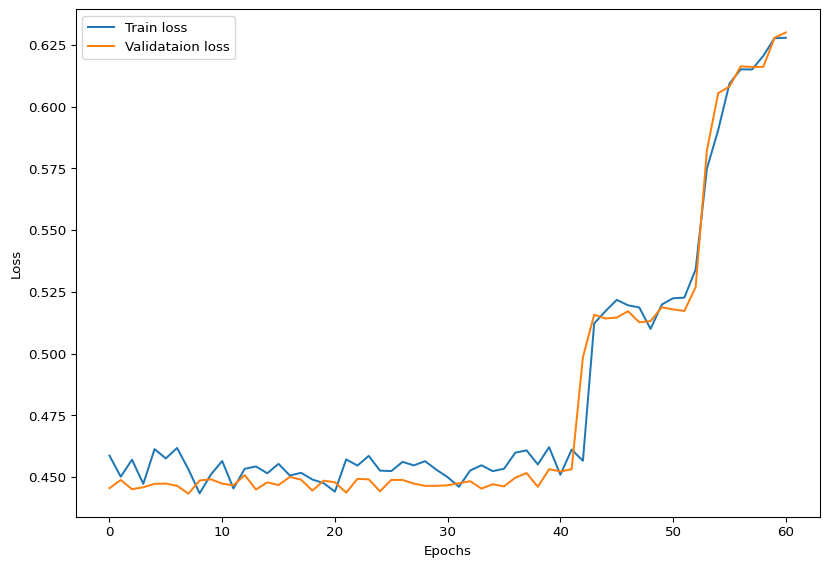

Mean train: 0.48512095646128617
Mean validataio: 0.4815211874464571


In [74]:
import matplotlib.pyplot as plt

# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()

mean_train_loss = np.mean(train_loss)
mean_valid_loss = np.mean(valid_loss)
print("Mean train:", mean_train_loss)
print("Mean validataio:", mean_valid_loss)

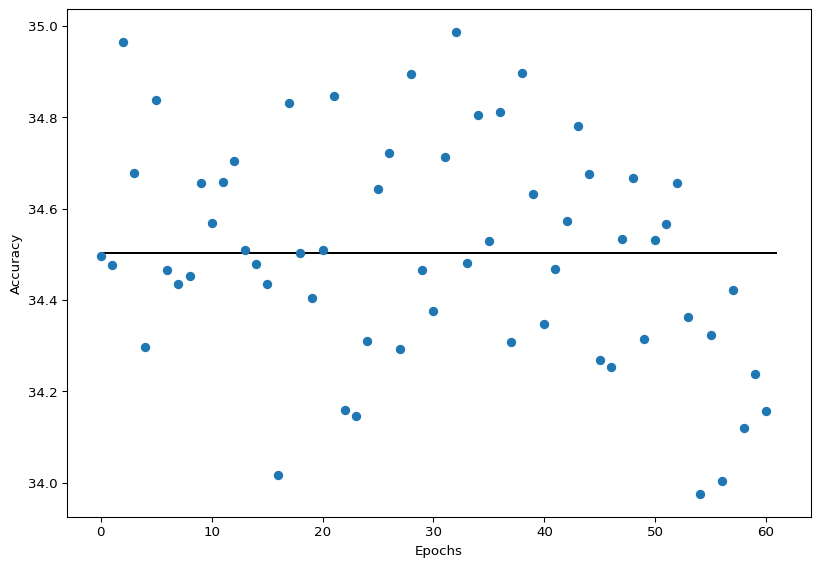

Mean accuray:  34.5%


In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(accuracy, 'o', label='Test Accuracy')
mean = np.mean(accuracy)
plt.hlines( mean, xmin=0,xmax=len(accuracy), label='Mean Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.legend()
plt.savefig('./outputs/accuracy.png')
plt.show()
print(f"Mean accuray:  {mean:>0.1f}%")

# Best 35

## 6. Saving Models


In [76]:
# save the trained model to disk
torch.save({
  'epoch': EPOCHS,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss_fn,
  },
  './outputs/model.pth'
)

## 7. Loading Models

In [77]:
# load the model checkpoint
checkpoint = torch.load('./outputs/model.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## 8. Predict

### get_random_data

In [78]:
def get_random_data(cvs_file_path):
  cvs_file = pd.read_csv(cvs_file_path)
  idx = np.random.choice(range(cvs_file.shape[0]))

  sgram_path = cvs_file["sgram"].iloc[idx]
  sgram = np.load(sgram_path)["arr_0"]
  # sgram = librosa.amplitude_to_db(sgram, ref=np.min)
  sgram = torch.tensor([sgram], dtype=torch.float32)

  label_path = cvs_file["label"].iloc[idx]
  label = np.load(label_path)["arr_0"]
  label = torch.tensor([label], dtype=torch.float32)

  print(sgram_path, sgram.shape, label_path, label.shape)
  return sgram, label

### Make a guess

/content/datasets/sgram_3175.npz torch.Size([1, 128, 3200]) /content/datasets/label_3175.npz torch.Size([1, 161])

Accuracy: 37.3%


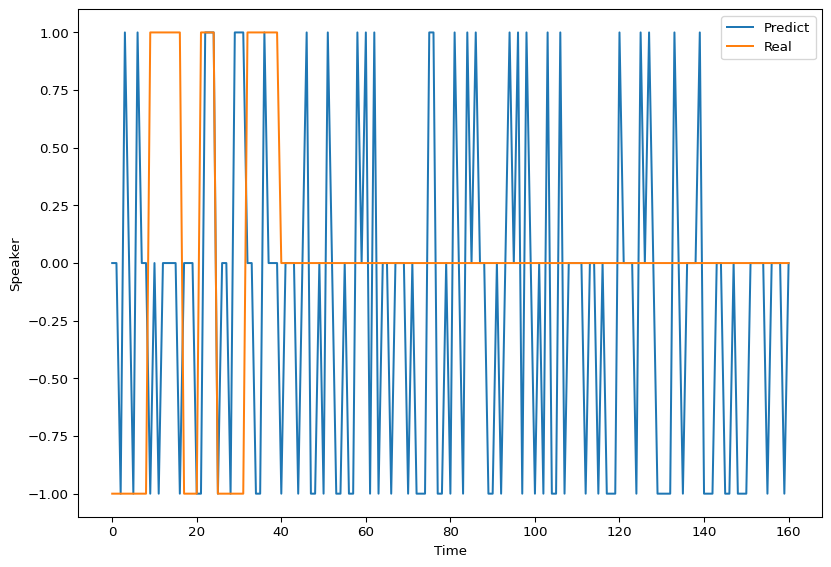

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def get_speaker(num):
  if num == 0:
    return "-"
  if num == 1:
    return "Speaker 1"
  if num == -1:
    return "Speaker 2"
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x, y = get_random_data(cvs_test_file_path)
x, y = x.to(device), y.to(device)

# x = x.unsqueeze(1)

model.eval()
with torch.no_grad():
  pred = model(x)
  accuracy = (y[0] == pred[0]).sum().item() / y[0].shape[0] * 100
  print(f"\nAccuracy: {accuracy:>0.1f}%")

arr_pred = pred[0].cpu()
arr_label = y[0].cpu()
# for i in range(len(arr_label)):
#   print(
#       i, 
#       get_speaker(arr_pred[i]),
#       get_speaker(arr_label[i]),
#     )

mpl.rcParams['figure.dpi'] = 96
plt.figure(figsize=(10, 7))
plt.plot(arr_pred, label='Predict')
plt.plot(arr_label, label='Real')
plt.xlabel('Time')
plt.ylabel('Speaker')
plt.legend()
plt.show()

# NOTAS COPY CODE

In [ ]:
import librosa
import torch
import torchaudio
import torchaudio.transforms as T

# file_path = "/content/manuel_adorni_and_leoco.wav" # 49
file_path = '/content/gdrive/MyDrive/QUTAP/Kolls/Equipo Técnico/kolls_dataaset_files/manuel_adorni_and_leoco.wav'

sample_rate = 16000
n_fft= 1024

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate
  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

transforms = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    n_mels=128
  )

# file_path = "/content/dataset_raw_files/es_ar_female/arf_00295_00020689215.wav"
waveform, sr = torchaudio.load(file_path, normalize=True)
if waveform.shape[0] > 1:
  waveform = torch.mean(waveform, dim=0, keepdim=True)

file_path = "/content/dataset_raw_files/es_ar_male/arm_00610_00107707160.wav"
waveform1, sr = torchaudio.load(file_path, normalize=True)
if waveform1.shape[0] > 1:
  waveform1 = torch.mean(waveform1, dim=0, keepdim=True)

waveform2 =  torch.cat((waveform,waveform1),1)

# spec = transforms(waveform)
# spec1 = transforms(waveform1)
# spec2 = transforms(waveform2)

# plot_spectrogram(spec)
# plot_spectrogram(spec1, title="1")
# plot_spectrogram(spec2, title="2")

aux_wave = waveform
hop_length = n_fft // 2

resampler = torchaudio.transforms.Resample(sr, sample_rate)
aux_wave = resampler(aux_wave)

frame_rate = sample_rate/hop_length
time = aux_wave.shape[1]/sample_rate
aux_spec = transforms(aux_wave)

print("Wave time:",time, "->", int(time*1000) , "in seg:", round(time))
print("Label:", round(aux_wave.shape[1]/sample_rate*1000) )
print("Spec time:", round(aux_spec.shape[2] / frame_rate*1000))

# crear label en seg, segun el spec
# con el nuevo del spec, cuandto tengo que agregar

# Reshaper spec
max_dim = aux_spec.shape[2]
max_dim = int(max_dim/128) + 1
max_dim = int(max_dim * 128)
temp = np.zeros((128, max_dim))
temp[:aux_spec.shape[1], :aux_spec.shape[2]] = aux_spec

# aux_spec.shape, temp.shape

new_spec_time= round(temp.shape[1] / frame_rate*1000)
print("Spec time:",new_spec_time)
print("Delta label:", new_spec_time - round(aux_wave.shape[1]/sample_rate*1000) )

In [ ]:
file_path = "/content/dataset_raw_files/es_ar_female/arf_00295_00020689215.wav"

hop_length = N_FFT// 2
frame_rate = SAMPLE_RATE/hop_length

aux_spec, aux_wave = get_specgram(file_path, sample_rate=SAMPLE_RATE)

time = aux_wave/sample_rate
print("Wave time:",time, "->", int(time*1000) , "in seg:", round(time))
print("Label:", round(aux_wave/sample_rate*1000) )
print("Spec time:", round(aux_spec.shape[2] / frame_rate*1000))

In [ ]:
x = torch.tensor([5,6,4], dtype=torch.float16)
y = torch.tensor([5,6,4], dtype=torch.float16)

aux_spec, _ = get_specgram(file_path, sample_rate=SAMPLE_RATE)
len(aux_spec[0])